In [15]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import datetime
import os

In [16]:
#Wind Power Production - Hourly Averaged Actual and Forecasted Values
url = 'http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13028&reportTitle=Wind%20Power%20Production%20-%20Hourly%20Averaged%20Actual%20and%20Forecasted%20Values&showHTMLView=&mimicKey'

In [17]:
response = requests.get(url)

In [18]:
soup = bs(response.text, 'html.parser')

In [19]:
title_results = soup.find_all('td', class_='labelOptional_ind')

In [20]:
url_results = soup.find_all('td', class_='labelOptional', text=True)

In [21]:
base_url = 'http://mis.ercot.com'

data_urls = []

for result in url_results:
    try:
        end_url = result.find('div').a['href']
        full_url = base_url + end_url
        data_urls.append(full_url)
        #print(full_url)
    except:
        pass

## Extract Zip File from URL

In [93]:
data = requests.get(data_urls[0], stream=True)

In [94]:
import requests, zipfile, io

z = zipfile.ZipFile(io.BytesIO(data.content))
z.extractall()
file = z.namelist()[0]

print(f'File Name: {file}')

File Name: cdr.00013028.0000000000000000.20200727.175518.WPPHRLYAVGACTNP4732.csv


In [95]:
#load zip file to df
wind_fcst = pd.read_csv(file)

#delete zip file after reading
os.remove(file)

In [96]:
wind_fcst

,DELIVERY_DATE,HOUR_ENDING,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STWPF_SYSTEM_WIDE,WGRPP_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,COP_HSL_LZ_SOUTH_HOUSTON,STWPF_LZ_SOUTH_HOUSTON,WGRPP_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,COP_HSL_LZ_WEST,STWPF_LZ_WEST,WGRPP_LZ_WEST,ACTUAL_LZ_NORTH,COP_HSL_LZ_NORTH,STWPF_LZ_NORTH,WGRPP_LZ_NORTH,DSTFlag
0,07/25/2020,19,11615.28,11091.1,11541.2,8171.9,3062.63,2565.8,3180.5,2556.7,8204.33,8102.6,8025.4,5389.7,348.32,422.7,335.3,225.5,N
1,07/25/2020,20,13013.58,11403.1,13033.6,9431.8,3017.51,2670.8,3180.2,2522.4,9605.64,8305.4,9422.4,6589.7,390.43,426.9,431.0,319.7,N
2,07/25/2020,21,13106.96,11223.7,13405.3,9814.5,2631.14,2574.6,2788.8,2140.2,10239.67,8382.8,10389.4,7535.8,236.15,266.3,227.1,138.5,N
3,07/25/2020,22,12548.09,12545.4,12638.2,9055.9,2382.70,2610.6,2569.0,1936.1,9900.46,9593.7,9806.9,6965.6,264.93,341.1,262.3,154.2,N
4,07/25/2020,23,13496.18,13135.8,13807.6,10231.8,2427.12,2485.7,2688.3,2067.7,10793.17,10403.1,10828.4,7983.6,275.89,247.0,290.9,180.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,08/03/2020,13,NaN,1638.7,1470.7,481.4,NaN,352.2,156.1,54.1,NaN,1253.2,1281.3,415.4,NaN,33.3,33.3,11.9,N
211,08/03/2020,14,NaN,1707.8,1538.1,510.1,NaN,408.4,217.2,77.5,NaN,1258.7,1280.2,417.4,NaN,40.7,40.7,15.2,N
212,08/03/2020,15,NaN,2279.7,2131.9,718.5,NaN,566.2,386.6,140.8,NaN,1641.7,1673.5,551.4,NaN,71.8,71.8,26.3,N
213,08/03/2020,16,NaN,2900.7,2777.1,948.6,NaN,733.6,566.0,204.2,NaN,2062.0,2106.0,705.8,NaN,105.1,105.1,38.6,N


In [130]:
#clean existing columns
wind_fcst['DELIVERY_DATE'] = pd.to_datetime(wind_fcst.DELIVERY_DATE).dt.normalize()

#add file name and process info to df
wind_fcst['FileName'] = z.namelist()[0]
wind_fcst['ProcessDate'] = pd.to_datetime(wind_fcst.FileName.str.split('.').str[3]).dt.normalize()
wind_fcst['ProcessHour'] = wind_fcst.FileName.str.split('.').str[4]
wind_fcst['ProcessDT'] = pd.to_datetime(wind_fcst.FileName.str.split('.').str[3] + wind_fcst.FileName.str.split('.').str[4])
wind_fcst['ProcessHour'] = wind_fcst.ProcessHour.str[0:2]

#change hour ending data type to string
wind_fcst.HOUR_ENDING = wind_fcst.HOUR_ENDING.astype(str)

#add delivery date time
wind_fcst['DeliveryDT'] = pd.to_datetime(wind_fcst.DELIVERY_DATE) + wind_fcst.HOUR_ENDING.astype('timedelta64[h]')

#add weekday columns
wind_fcst['Weekday'] = wind_fcst.DeliveryDT.dt.day_name().str.upper()

In [131]:
wind_fcst.head()

,DELIVERY_DATE,HOUR_ENDING,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STWPF_SYSTEM_WIDE,WGRPP_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,COP_HSL_LZ_SOUTH_HOUSTON,STWPF_LZ_SOUTH_HOUSTON,WGRPP_LZ_SOUTH_HOUSTON,...,COP_HSL_LZ_NORTH,STWPF_LZ_NORTH,WGRPP_LZ_NORTH,DSTFlag,FileName,ProcessDate,ProcessHour,ProcessDT,DeliveryDT,Weekday
0,2020-07-25,19,11615.28,11091.1,11541.2,8171.9,3062.63,2565.8,3180.5,2556.7,...,422.7,335.3,225.5,N,cdr.00013028.0000000000000000.20200727.175518....,2020-07-27,17,2020-07-27 17:55:18,2020-07-25 19:00:00,SATURDAY
1,2020-07-25,20,13013.58,11403.1,13033.6,9431.8,3017.51,2670.8,3180.2,2522.4,...,426.9,431.0,319.7,N,cdr.00013028.0000000000000000.20200727.175518....,2020-07-27,17,2020-07-27 17:55:18,2020-07-25 20:00:00,SATURDAY
2,2020-07-25,21,13106.96,11223.7,13405.3,9814.5,2631.14,2574.6,2788.8,2140.2,...,266.3,227.1,138.5,N,cdr.00013028.0000000000000000.20200727.175518....,2020-07-27,17,2020-07-27 17:55:18,2020-07-25 21:00:00,SATURDAY
3,2020-07-25,22,12548.09,12545.4,12638.2,9055.9,2382.70,2610.6,2569.0,1936.1,...,341.1,262.3,154.2,N,cdr.00013028.0000000000000000.20200727.175518....,2020-07-27,17,2020-07-27 17:55:18,2020-07-25 22:00:00,SATURDAY
4,2020-07-25,23,13496.18,13135.8,13807.6,10231.8,2427.12,2485.7,2688.3,2067.7,...,247.0,290.9,180.5,N,cdr.00013028.0000000000000000.20200727.175518....,2020-07-27,17,2020-07-27 17:55:18,2020-07-25 23:00:00,SATURDAY


In [132]:
wind_fcst.describe()

,ACTUAL_SYSTEM_WIDE,COP_HSL_SYSTEM_WIDE,STWPF_SYSTEM_WIDE,WGRPP_SYSTEM_WIDE,ACTUAL_LZ_SOUTH_HOUSTON,COP_HSL_LZ_SOUTH_HOUSTON,STWPF_LZ_SOUTH_HOUSTON,WGRPP_LZ_SOUTH_HOUSTON,ACTUAL_LZ_WEST,COP_HSL_LZ_WEST,STWPF_LZ_WEST,WGRPP_LZ_WEST,ACTUAL_LZ_NORTH,COP_HSL_LZ_NORTH,STWPF_LZ_NORTH,WGRPP_LZ_NORTH
count,47.000000,215.000000,215.000000,215.000000,47.000000,215.000000,215.000000,215.000000,47.000000,215.000000,215.000000,215.000000,47.000000,215.000000,215.000000,215.000000
mean,7456.702979,6943.808837,6930.069767,4042.835349,2112.464255,1785.668837,1709.127907,996.760000,5129.305957,4828.646047,4894.849302,2849.160930,214.932766,329.493953,326.092558,196.914419
std,3121.751826,3669.857433,3756.589149,2723.710596,752.290393,907.232189,936.112001,670.413749,2729.902442,2955.837368,3000.412641,2182.526489,130.980488,219.478125,222.790624,168.817398
min,1986.870000,756.200000,568.500000,184.100000,581.100000,350.200000,156.100000,53.500000,1324.960000,331.800000,337.700000,100.700000,12.490000,23.500000,12.200000,4.700000
25%,5556.635000,3777.650000,3737.050000,1675.400000,1352.365000,1017.750000,931.750000,413.950000,2868.200000,2288.700000,2406.900000,1021.250000,68.955000,164.000000,154.850000,71.950000
50%,6701.570000,6869.000000,6789.800000,3787.300000,2382.700000,1604.300000,1562.400000,854.300000,4613.940000,4426.300000,4437.500000,2379.800000,242.390000,281.600000,281.600000,141.200000
75%,9631.825000,9542.250000,9584.450000,5727.400000,2693.460000,2612.050000,2548.100000,1534.200000,7381.190000,6914.050000,7001.450000,4279.150000,342.770000,426.300000,429.700000,271.400000
max,13496.180000,15803.100000,15964.000000,11438.000000,3104.010000,3660.700000,3660.700000,2556.700000,10793.170000,11944.700000,12105.600000,8769.200000,428.370000,913.600000,913.600000,733.400000


In [133]:
wind_fcst.dtypes

DELIVERY_DATE               datetime64[ns]
HOUR_ENDING                         object
ACTUAL_SYSTEM_WIDE                 float64
COP_HSL_SYSTEM_WIDE                float64
STWPF_SYSTEM_WIDE                  float64
WGRPP_SYSTEM_WIDE                  float64
ACTUAL_LZ_SOUTH_HOUSTON            float64
COP_HSL_LZ_SOUTH_HOUSTON           float64
STWPF_LZ_SOUTH_HOUSTON             float64
WGRPP_LZ_SOUTH_HOUSTON             float64
ACTUAL_LZ_WEST                     float64
COP_HSL_LZ_WEST                    float64
STWPF_LZ_WEST                      float64
WGRPP_LZ_WEST                      float64
ACTUAL_LZ_NORTH                    float64
COP_HSL_LZ_NORTH                   float64
STWPF_LZ_NORTH                     float64
WGRPP_LZ_NORTH                     float64
DSTFlag                             object
FileName                            object
ProcessDate                 datetime64[ns]
ProcessHour                         object
ProcessDT                   datetime64[ns]
DeliveryDT 

### Convert DF to Long Format (i.e. Unpivot Forecast columns)

In [134]:
#use pd.melt to unpivot columns
long_wind_fcst = pd.melt(wind_fcst, id_vars=['DELIVERY_DATE', 'HOUR_ENDING', 'DSTFlag', 'FileName', 'ProcessDate', 'ProcessHour', 'ProcessDT', 'DeliveryDT', 'Weekday'],var_name='WindZone', value_name ='MW')

#extract type and zone from WindZone column
long_wind_fcst['Type'] = long_wind_fcst.WindZone.str.split('_').str[0]
long_wind_fcst['Zone'] = long_wind_fcst.WindZone.str.split('_', n=1).str[1]


#rename columns
long_wind_fcst = long_wind_fcst.rename(columns = {'DeliveryDT':'delivery_dt', 'DELIVERY_DATE':'delivery_date', 'HOUR_ENDING':'delivery_hour', 
                                                  'DSTFlag':'dst_flag', 'Weekday':'weekday', 'Type':'type', 'Zone':'zone', 'MW':'mw', 
                                                  'ProcessDate':'process_date', 'ProcessHour':'process_hour', 'ProcessDT':'process_dt', 'FileName':'file_name'}, inplace=False)
#reorder columns
arranged_columns = ['delivery_dt', 'delivery_date', 'delivery_hour', 'dst_flag', 'weekday', 'type', 'zone', 'mw', 'process_date', 'process_hour',
                    'process_dt', 'file_name']

long_wind_fcst = long_wind_fcst[arranged_columns]

long_wind_fcst

,delivery_dt,delivery_date,delivery_hour,dst_flag,weekday,type,zone,mw,process_date,process_hour,process_dt,file_name
0,2020-07-25 19:00:00,2020-07-25,19,N,SATURDAY,ACTUAL,SYSTEM_WIDE,11615.28,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
1,2020-07-25 20:00:00,2020-07-25,20,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13013.58,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
2,2020-07-25 21:00:00,2020-07-25,21,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13106.96,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3,2020-07-25 22:00:00,2020-07-25,22,N,SATURDAY,ACTUAL,SYSTEM_WIDE,12548.09,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
4,2020-07-25 23:00:00,2020-07-25,23,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13496.18,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
...,...,...,...,...,...,...,...,...,...,...,...,...
3435,2020-08-03 13:00:00,2020-08-03,13,N,MONDAY,WGRPP,LZ_NORTH,11.90,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3436,2020-08-03 14:00:00,2020-08-03,14,N,MONDAY,WGRPP,LZ_NORTH,15.20,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3437,2020-08-03 15:00:00,2020-08-03,15,N,MONDAY,WGRPP,LZ_NORTH,26.30,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3438,2020-08-03 16:00:00,2020-08-03,16,N,MONDAY,WGRPP,LZ_NORTH,38.60,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....


## Plotting Forecasts

In [135]:
import plotly.express as px

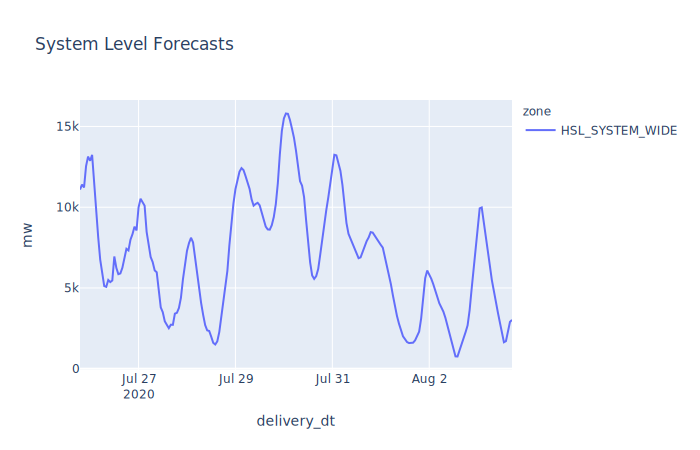

In [142]:
system_df = long_wind_fcst.loc[(long_wind_fcst.type == 'COP') & (long_wind_fcst.zone == 'HSL_SYSTEM_WIDE'), :] 

system_df.head()

systemFig = px.line(system_df, x="delivery_dt", y="mw", title='System Level Forecasts', color = 'zone')

systemFig.show('svg')

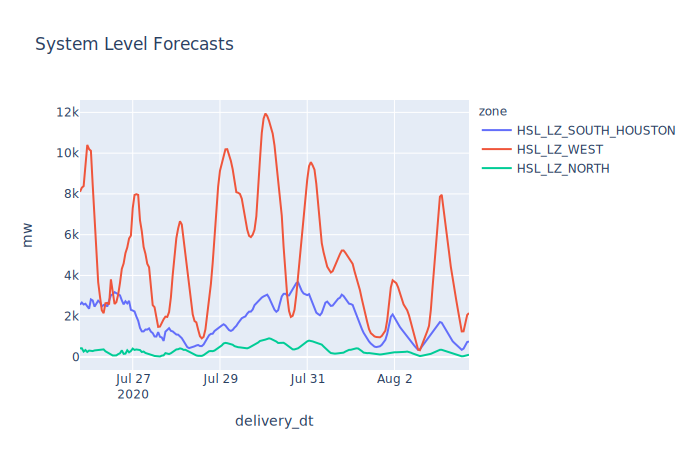

In [143]:
zonal_df = long_wind_fcst.loc[(long_wind_fcst.type == 'COP') & (long_wind_fcst.zone != 'HSL_SYSTEM_WIDE'), :] 

zonalFig = px.line(zonal_df, x="delivery_dt", y="mw", title='System Level Forecasts', color = 'zone')

zonalFig.show('svg')

## Load Data to PostgreSQL Database

In [138]:
from sqlalchemy import create_engine

In [139]:
connection_string = f"postgres:trumpet5@localhost:5432/ercot_db"
engine = create_engine(f'postgresql://{connection_string}')

In [140]:
#fill table
long_wind_fcst.to_sql(name='da_wind_fcst', con=engine, if_exists='append', index=False)

In [141]:
#Print Table
pd.read_sql_query('select * from da_wind_fcst', con=engine)

,delivery_dt,delivery_date,delivery_hour,dst_flag,weekday,type,zone,mw,process_date,process_hour,process_dt,file_name
0,2020-07-25 19:00:00,2020-07-25,19,N,SATURDAY,ACTUAL,SYSTEM_WIDE,11615.28,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
1,2020-07-25 20:00:00,2020-07-25,20,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13013.58,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
2,2020-07-25 21:00:00,2020-07-25,21,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13106.96,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3,2020-07-25 22:00:00,2020-07-25,22,N,SATURDAY,ACTUAL,SYSTEM_WIDE,12548.09,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
4,2020-07-25 23:00:00,2020-07-25,23,N,SATURDAY,ACTUAL,SYSTEM_WIDE,13496.18,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
...,...,...,...,...,...,...,...,...,...,...,...,...
3435,2020-08-03 13:00:00,2020-08-03,13,N,MONDAY,WGRPP,LZ_NORTH,11.90,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3436,2020-08-03 14:00:00,2020-08-03,14,N,MONDAY,WGRPP,LZ_NORTH,15.20,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3437,2020-08-03 15:00:00,2020-08-03,15,N,MONDAY,WGRPP,LZ_NORTH,26.30,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
3438,2020-08-03 16:00:00,2020-08-03,16,N,MONDAY,WGRPP,LZ_NORTH,38.60,2020-07-27,17,2020-07-27 17:55:18,cdr.00013028.0000000000000000.20200727.175518....
